In [6]:
import os
import time
import random
import warnings
import matplotlib
import numpy as np
import pandas as pd
import tushare as ts
from pylab import mpl
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.datasets import load_boston
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score          #预测准确度评分函数
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from matplotlib.font_manager import FontProperties
from sklearn.ensemble import RandomForestClassifier #分类决策树模型
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [12]:
path = ('沪深300.csv')
data=pd.read_csv(path,index_col=0)
data.head(10)

,name
0,002812.SZ
1,002607.SZ
2,600030.SH
3,600809.SH
4,002027.SZ
5,600299.SH
6,002044.SZ
7,300122.SZ
8,601360.SH
9,002594.SZ


In [14]:
import time
pro = ts.pro_api('f2e84cc167f1bfc5d2434907f1b2a083cea5119932748024199a7c3c')
df1 = pd.read_csv(path,index_col=0) #读取沪深300名单
df2 = pd.DataFrame()
for i in range(int(df1.shape[0])): #df1.shape[0]是dataframe的行数
    name = df1.iloc[i,0]
    df = pro.daily(ts_code=name, start_date='20150101', end_date='20201231')
    df2 = pd.concat([df2,df])
    print(i)
df2

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,002812.SZ,20201231,139.47,142.65,136.70,141.78,139.00,2.78,2.0000,65732.55,9.212705e+05
1,002812.SZ,20201230,135.64,143.00,135.00,139.00,136.37,2.63,1.9286,70129.76,9.762302e+05
2,002812.SZ,20201229,138.65,139.80,132.00,136.37,139.25,-2.88,-2.0682,70364.81,9.512133e+05
3,002812.SZ,20201228,138.00,139.97,135.81,139.25,138.21,1.04,0.7525,54875.46,7.583881e+05
4,002812.SZ,20201225,139.69,142.29,135.00,138.21,137.80,0.41,0.2975,54871.99,7.586188e+05
...,...,...,...,...,...,...,...,...,...,...,...
1457,601318.SH,20150109,71.20,78.18,70.72,72.84,71.08,1.76,2.4800,3118734.02,2.316418e+07
1458,601318.SH,20150108,74.50,74.92,70.80,71.08,73.41,-2.33,-3.1700,1788809.15,1.288382e+07
1459,601318.SH,20150107,73.30,75.50,72.50,73.41,73.73,-0.32,-0.4300,1703868.84,1.256595e+07
1460,601318.SH,20150106,74.38,76.77,72.01,73.73,76.16,-2.43,-3.1900,2342279.69,1.743863e+07


In [16]:
df2.columns.tolist()    #读取数据列索引,做数据清洗
df = df2.sort_values(by = ['trade_date'])
df = df[['open','high','low','close','pre_close','change','pct_chg','vol','amount','ts_code','trade_date']]
df['price_change'] = df['close'] - df['pre_close']
df['change_rate'] = (df['price_change']/df['close'])*100
df['price_change'] = df['close'] - df['pre_close']
df['change_rate'] = (df['price_change']/df['close'])*100
df
#五分类赋值函数
def fun(x):
    if x <= -5:
        return 5
    elif x < -1 and x > -5:
        return 4
    elif x < 1 and x >= -1:
        return 3
    elif x < 5 and x >= 1:
        return 2
    elif x >= 5:
        return 1
values= df['change_rate'].apply(lambda x: fun(x))
df['change_rate'] = values
df #计算出收益率,并以-5，-1，1，5为界分为五大类并赋值

,open,high,low,close,pre_close,change,pct_chg,vol,amount,ts_code,trade_date,price_change,change_rate
1461,77.80,78.80,75.25,76.16,74.71,1.45,1.9400,2435717.73,1.875204e+07,601318.SH,20150105,1.45,2
1431,3.39,3.68,3.39,3.65,3.38,0.27,7.9900,8915831.97,3.185986e+06,601899.SH,20150105,0.27,1
1294,11.16,11.39,10.89,11.26,11.12,0.14,1.2600,46383.57,5.155929e+04,600848.SH,20150105,0.14,2
1369,7.00,7.50,6.98,7.47,7.01,0.46,6.5600,2376330.79,1.742213e+06,600019.SH,20150105,0.46,1
1461,12.28,12.55,12.28,12.45,12.28,0.17,1.3800,104561.41,1.299123e+05,002311.SZ,20150105,0.17,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,85.59,87.68,85.59,86.98,85.88,1.10,1.2809,795809.39,6.906072e+06,601318.SH,20201231,1.10,2
0,5.35,5.42,5.30,5.37,5.36,0.01,0.1866,594297.57,3.185052e+05,000425.SZ,20201231,0.01,3
0,156.01,156.98,153.53,155.55,155.60,-0.05,-0.0321,41837.67,6.493398e+05,603160.SH,20201231,-0.05,3
0,55.00,56.19,54.10,55.43,54.78,0.65,1.1866,59130.07,3.263388e+05,601021.SH,20201231,0.65,2


In [17]:
#归一化函数
def stand(x):
    a = (x-mins)/(maxs-mins)
    return a
#最大最小归一化
names = ['open','high','low','close','pre_close','change','pct_chg','vol','amount']
for i in names:
    maxs = df.loc[:,i].max()
    mins = df.loc[:,i].min()
    values= df[i].apply(lambda x: stand(x))
    df[i] = values
df

,open,high,low,close,pre_close,change,pct_chg,vol,amount,ts_code,trade_date,price_change,change_rate
1461,0.039568,0.038906,0.038293,0.037612,0.038127,0.380888,0.083573,0.047429,0.276003,601318.SH,20150105,1.45,2
1431,0.001211,0.001306,0.001213,0.001302,0.001206,0.377677,0.106623,0.173613,0.046893,601899.SH,20150105,0.27,1
1294,0.005217,0.005165,0.005083,0.005113,0.005212,0.377323,0.080982,0.000903,0.000759,600848.SH,20150105,0.14,2
1369,0.003072,0.003218,0.003065,0.003215,0.003085,0.378194,0.101175,0.046273,0.025643,600019.SH,20150105,0.46,1
1461,0.005794,0.005746,0.005800,0.005709,0.005813,0.377405,0.081439,0.002036,0.001912,002311.SZ,20150105,0.17,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.043583,0.043350,0.043628,0.043031,0.043909,0.379935,0.081062,0.015496,0.101647,601318.SH,20201231,1.10,2
0,0.002222,0.002177,0.002198,0.002163,0.002231,0.376969,0.076893,0.011572,0.004688,000425.SZ,20201231,0.01,3
0,0.079883,0.078037,0.078686,0.077368,0.079997,0.376806,0.076060,0.000815,0.009557,603160.SH,20201231,-0.05,3
0,0.027815,0.027589,0.027379,0.027232,0.027811,0.378711,0.080703,0.001151,0.004803,601021.SH,20201231,0.65,2


In [18]:
#数据切分
df1 = df[df['trade_date']<'20180101']
df2 = df[df['trade_date']>'20180101']
#设定测试集和训练集
X_train = df1.iloc[:,:9]   
Y_train = df1.loc[:,'change_rate']
X_test = df2.iloc[:,:9]
Y_test = df2.loc[:,'change_rate']
X_train

,open,high,low,close,pre_close,change,pct_chg,vol,amount
1461,0.039568,0.038906,0.038293,0.037612,0.038127,0.380888,0.083573,0.047429,0.276003
1431,0.001211,0.001306,0.001213,0.001302,0.001206,0.377677,0.106623,0.173613,0.046893
1294,0.005217,0.005165,0.005083,0.005113,0.005212,0.377323,0.080982,0.000903,0.000759
1369,0.003072,0.003218,0.003065,0.003215,0.003085,0.378194,0.101175,0.046273,0.025643
1461,0.005794,0.005746,0.005800,0.005709,0.005813,0.377405,0.081439,0.002036,0.001912
...,...,...,...,...,...,...,...,...,...
730,0.006041,0.005906,0.006048,0.005884,0.006077,0.376969,0.076487,0.001032,0.000999
730,0.008021,0.007878,0.008029,0.007862,0.008059,0.377296,0.079154,0.000290,0.000366
730,0.015289,0.015416,0.014711,0.014557,0.014452,0.380071,0.091307,0.004362,0.010060
718,0.040712,0.039952,0.039970,0.039650,0.041450,0.374493,0.071953,0.002316,0.013940


In [19]:
change_rate = df.loc[:,'change_rate']  #取出change_rate列
change_rate.unique()  #change_rate列有哪些值
change_rate.value_counts()  #对各个值计数

3    157457
2     93095
4     92121
1     16140
5     14140
Name: change_rate, dtype: int64

In [21]:
#显著非平衡，用smote过抽样
#定义SMOTE模型，random_state相当于随机数种子的作用
smo = SMOTE(random_state=42)
X_smo, y_smo = smo.fit_sample(X_train,Y_train)
X_smo

array([[0.03956783, 0.03890566, 0.03829284, ..., 0.08357301, 0.04742924,
        0.27600347],
       [0.00121137, 0.00130637, 0.00121262, ..., 0.10662274, 0.17361281,
        0.04689298],
       [0.0052166 , 0.0051654 , 0.00508266, ..., 0.08098229, 0.0009031 ,
        0.00075862],
       ...,
       [0.00781822, 0.00773627, 0.00730807, ..., 0.05669246, 0.00607457,
        0.00733179],
       [0.00969142, 0.00948341, 0.00881966, ..., 0.04316389, 0.00414214,
        0.00587863],
       [0.00889752, 0.00887968, 0.00834092, ..., 0.03880536, 0.03482052,
        0.04668054]])

In [22]:
#模型设定，拟合
model1 = RandomForestClassifier(max_depth=4, n_estimators=10, min_samples_leaf=5, random_state=1)
model1.fit(X_smo, y_smo)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [23]:
#用测试集预测
y_pred = model1.predict(X_test)
a = pd.DataFrame()
a['预测值'] = list(y_pred)
a['实际值'] = list(Y_test)
a

,预测值,实际值
0,4,3
1,3,3
2,1,1
3,3,3
4,3,3
...,...,...
204531,2,2
204532,3,3
204533,3,3
204534,2,2


In [25]:
#画图
def plot_Matrix(name, cm, classes, title=None,  cmap=plt.cm.Blues):
    plt.rc('font',family='Times New Roman',size='8')   # 设置字体样式、大小
    
    # 按行进行归一化
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
    str_cm = cm.astype(np.str).tolist()
    for row in str_cm:
        print('\t'.join(row))
    # 占比1%以下的单元格，设为0，防止在最后的颜色中体现出来
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if int(cm[i, j]*100 + 0.5) == 0:
                cm[i, j]=0

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    # ax.figure.colorbar(im, ax=ax) # 侧边的颜色条带
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Actual',
           xlabel='Predicted')

    # 通过绘制格网，模拟每个单元格的边框
    ax.set_xticks(np.arange(cm.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(cm.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.2)
    ax.tick_params(which="minor", bottom=False, left=False)

    # 将x轴上的lables旋转45度
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    

    # 标注百分比信息
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if int(cm[i, j]*100 + 0.5) > 0:
                ax.text(j, i, format(int(cm[i, j]*100 + 0.5) , fmt) + '%',
                        ha="center", va="center",
                        color="white"  if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.savefig('{}.jpg'.format(name), dpi=300)
    plt.show()

Normalized confusion matrix
0.9996018051499868	0.00039819485001327314	0.0	0.0	0.0
0.00017206110080868718	0.9995794061980232	0.0002485327011681037	0.0	0.0
2.362781466342178e-05	0.0523946790161378	0.8835266876166623	0.06405500555253645	0.0
0.0	0.0	0.0006106926735385014	0.9992782722949091	0.0001110350315524548
0.0	0.0	0.0	0.00016633399866932801	0.9998336660013307


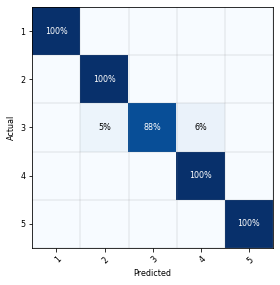

In [26]:
#得到混淆矩阵
cm = confusion_matrix(Y_test, y_pred)
#画混淆矩阵
classes = ['1','2','3','4','5']
plot_Matrix('cm_randomforest',cm, classes, title=None,  cmap=plt.cm.Blues)


#因为收益划分区间太大了，所以在3%-5%的误差允许内预测的精度如下，不得不说这是一个遗憾。--liujing

In [27]:
#分析特征变量的特征重要性
features = X_test.iloc[:,0:18].columns
importances = model1.feature_importances_
c = pd.DataFrame()
c['特征'] = features
c['特征重要性'] = importances
c = c.sort_values('特征重要性', ascending=False)
c

,特征,特征重要性
6,pct_chg,0.691750
5,change,0.263487
8,amount,0.027144
7,vol,0.009829
2,low,0.002638
3,close,0.002144
1,high,0.001832
0,open,0.000924
4,pre_close,0.000252


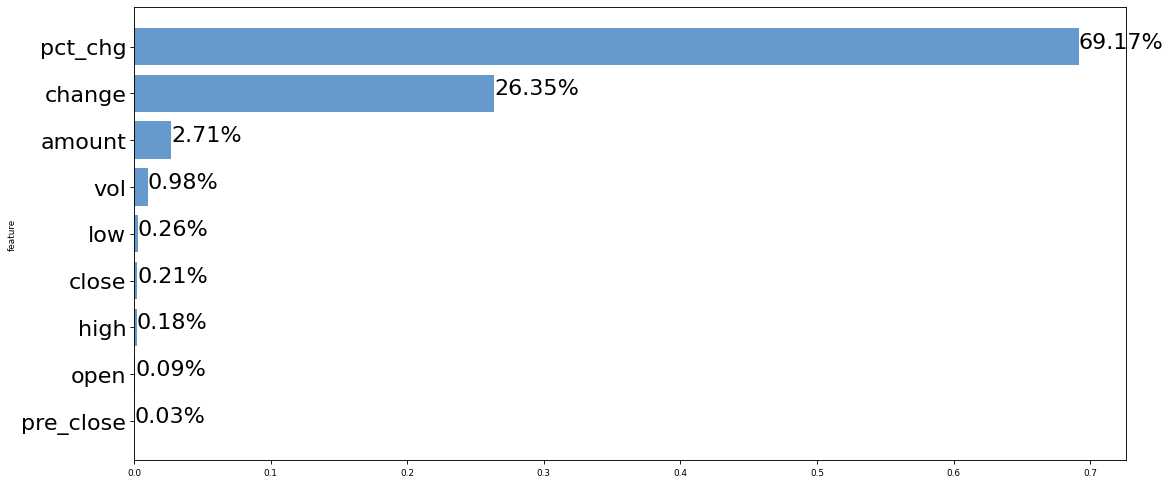

In [28]:
c.sort_values(by='特征重要性',inplace=True)
#数据
name=c.iloc[:,0]
colleges=c.iloc[:,1]
fig,ax=plt.subplots(figsize=(16, 7.5), dpi=80)
b=ax.barh(range(len(name)),colleges,color='#6699CC')
plt.ylabel('feature')
ax.set_yticks(range(len(name)))
ax.set_yticklabels(name, fontsize = 20)
plt.rc('font', size=30) 
plt.rc('axes', titlesize=20) 
lis = list(colleges)
lens = []
for i in range(len(lis)):
    lens.append(i)
for a,b in zip(lis,lens):
        plt.text(a,b+0.1,'{:.2f}%'.format(a*100),ha = 'left',va = 'center',fontsize=20)    
plt.savefig('特征重要性1.jpg')
plt.show()

In [ ]:
#显然看出来pct_chg(投资收益率)这个特征值的权重大，对股价的影响大。